# Figure 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path as P
from scipy.stats import pearsonr

## Settings

In [3]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [4]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [5]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Load Data

### UMAPs

In [6]:
adatas = {
    donor: {
        model: sc.read(f'../results/fig1_{model}_{donor}_full.h5ad') 
        for model in ['moe', 'poe', 'concat', 'rna', 'tcr']
    }
    for donor in ['donor_1', 'donor_2', 'donor_3', 'donor_4', 'None', ]
}
adatas_fig = adatas['None']
adatas_fig['rna'].obs['leiden2_ct'] = adatas_fig['rna'].obs['leiden2_ct'].astype(str)
adatas_fig['moe'].obs['leiden2_ct'] = adatas_fig['moe'].obs['leiden2_ct'].astype(str)

adatas_fig['rna'].obs['leiden_rna'] = adatas_fig['rna'].obs['leiden'].astype(str)

In [7]:
mapper_binding = {'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 'IVTDFSVIK',
          'A0301_KLGGALQAK_IE-1_CMV_binder': 'KLGGALQAK',
          'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 'GILGFVFTL',
          'A0201_ELAGIGILTV_MART-1_Cancer_binder': 'ELAGIGILTV', 
          'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 'AVFDRKSDAK',
          'A0201_GLCTLVAML_BMLF1_EBV_binder': 'GLCTLVAML',
          'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 'RLRAEAQVK',
          'B0801_RAKFKQLL_BZLF1_EBV_binder': 'RAKFKQLL'}

In [8]:
mapper_celltype = {
    'Tem/Trm cytotoxic T cells': 'Eff/Rest memory',
    'Tcm/Naive cytotoxic T cells': 'Naive',
    'Tem/Temra cytotoxic T cells': 'Effector memory',
    'Unknown': 'Others', 
    'MAIT cells': 'MAIT', 
    'Trm cytotoxic T cells': 'Resting memory',
    'NKT cells': 'NKT',
}

In [9]:
mapper_donor = {
    'donor_1': 'Donor 1',
    'donor_2': 'Donor 2',
    'donor_3': 'Donor 3',
    'donor_4': 'Donor 4',
}

In [10]:
for adatas_tmp in adatas.values():
    for ad in adatas_tmp.values():
        ad.obs['binding_name'] = ad.obs['binding_name'].map(mapper_binding)
        ad.obs['celltype'] = ad.obs['celltype'].map(mapper_celltype)
        ad.obs['donor'] = ad.obs['donor'].map(mapper_donor)

In [11]:
rna_conservation = adatas_fig['moe'].uns['rna_conservation']
rna_conservation = rna_conservation.replace({'rna': 'RNA', 'tcr': 'TCR'})

In [12]:
adatas_fig['moe']

AnnData object with n_obs × n_vars = 61237 × 40
    obs: 'batch', 'donor', 'binding_name', 'clonotype', 'large_clonotype', 'celltype', 'Contribution TCR', 'leiden', 'treg_score', 'cd4 nv/cm_score', 'cd4/cd8_score', 'ifn response_score', 'proliferation_score', 'cd8 cytotoxic_score', 'cd8 cytokine_score', 'leiden_rna', 'leiden2_ct'
    uns: 'binding_name_colors', 'clones_per_cluster', 'corr_mvtcr_rna', 'leiden', 'leiden_colors', 'neighbors', 'pw_tcrdist', 'rna_conservation', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:
clones_per_cluster = adatas_fig['moe'].uns['clones_per_cluster']
corr_mvtcr_rna = adatas_fig['moe'].uns['corr_mvtcr_rna']

## TCRdist

In [14]:
bindings = []
dists = []

for b, d in adatas_fig['moe'].uns['pw_tcrdist'].items():
    bindings += [b.split('_')[1]] * len(d)
    dists += d.tolist()
    
df_dists = pd.DataFrame(data={'Binder': bindings, 'TCRdist': dists})
df_dists['TCR Similarity'] = df_dists['TCRdist'].max() - df_dists['TCRdist']

# Comment out before publication
#df_dists = df_dists.sample(n=1000000)

In [15]:
x = pd.DataFrame(df_dists.groupby('Binder')['TCR Similarity'].mean())
x.index.name = None
y = pd.DataFrame(adatas_fig['moe'].obs.groupby('binding_name')['Contribution TCR'].mean())
y['binding_name'] = y.index.str.split('_').str[1]
y.index.name = None

df_contribution_dists = pd.concat([x, y], axis=1)
df_contribution_dists['binding_name'] = df_contribution_dists.index
df_contribution_dists = df_contribution_dists.rename(columns={'Contribution TCR': 'Contribution Score'})
df_contribution_dists

TCR Similarity  Contribution Score binding_name
AVFDRKSDAK      243.099801            0.509496   AVFDRKSDAK
ELAGIGILTV      302.742986            0.517691   ELAGIGILTV
GILGFVFTL       318.749562            0.553778    GILGFVFTL
GLCTLVAML       266.928773            0.547759    GLCTLVAML
IVTDFSVIK       249.937158            0.529778    IVTDFSVIK
KLGGALQAK       241.503338            0.480070    KLGGALQAK
RAKFKQLL        277.277746            0.504218     RAKFKQLL
RLRAEAQVK       238.997472            0.473449    RLRAEAQVK

## Settings

In [16]:
cp_clone = sb.color_palette('colorblind')

colors_clonotypes = ['lightgray', cp_clone[3], cp_clone[9], 
                     cp_clone[8], cp_clone[6], cp_clone[5], 
                     cp_clone[4], cp_clone[0], cp_clone[2], 
                     cp_clone[1],]

cp_bind = sb.color_palette('deep')
colors_binders = {
    'KLGGALQAK': cp_bind[8],
    'RAKFKQLL': cp_bind[2],
    'GILGFVFTL': cp_bind[1],
    'IVTDFSVIK': cp_bind[4],
    'AVFDRKSDAK': cp_bind[0],
    'GLCTLVAML': cp_bind[3],
    'RLRAEAQVK': cp_bind[9],
    'ELAGIGILTV': cp_bind[5],
    }

cp_type = sb.color_palette('tab10')
colors_celltype = {
    'Eff/Rest memory': cp_type[3],
    'Effector memory': cp_type[0],
    'Naive': cp_type[2],
    'Others': 'lightgray', # cp_type[8],
    'MAIT': cp_type[4],
    'Resting memory': cp_type[5],
    'NKT': cp_type[1],
}
colors_donor = {
    'Donor 1': cp_type[2],
    'Donor 2': cp_type[1],
    'Donor 3': cp_type[3],
    'Donor 4': cp_type[0],
}

color_contribution = 'coolwarm'

### Format Sankey data

In [17]:
df_sankey = adatas_fig['moe'].obs[['leiden', 'binding_name']].copy()
df_sankey = df_sankey.rename(columns={'leiden': 'leiden_moe'})
df_sankey['leiden_rna'] = adatas_fig['rna'].obs['leiden']

cp_bind = sb.color_palette('deep')
colors_binders = {
    'KLGGALQAK': cp_bind[8],
    'RAKFKQLL': cp_bind[2],
    'GILGFVFTL': cp_bind[1],
    'IVTDFSVIK': cp_bind[4],
    'AVFDRKSDAK': cp_bind[0],
    'GLCTLVAML': cp_bind[3], 
    'RLRAEAQVK': cp_bind[9],
    'ELAGIGILTV': cp_bind[5],
}
colors_moe = dict(zip(adatas_fig['moe'].obs['leiden'].value_counts().index, 
                      reversed(adatas_fig['moe'].uns['leiden_colors'])))
colors_rna = dict(zip(adatas_fig['rna'].obs['leiden'].value_counts().index, 
                      reversed(adatas_fig['rna'].uns['leiden_colors'])))

color_regplot = 'silver'

## Plotting Functions

### Umaps

In [18]:
def plot_umap(adata, grouping, ax, legend=None, ylabel=None, xlabel=None, size=0.2, bbox=1.6, cmap=None, bbox2=0.5):
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    
    palette = None
    vmin, vmax = None, None
    if grouping == 'donor':
        palette = colors_donor
    if grouping == 'celltype':
        palette = colors_celltype
    if grouping == 'binding_name':
        palette = colors_binders
    if grouping == 'large_clonotype':
        palette = dict(zip(adata.obs['large_clonotype'].value_counts().index, colors_clonotypes))
    if grouping == 'Contribution TCR':
        palette = color_contribution
        vmin = np.percentile(adata.obs[grouping].values, 1)
        vmax = np.percentile(adata.obs[grouping].values, 99)
        colors = np.clip(colors, vmin, vmax)
    if grouping == 'cd8 cytotoxic_score':
        palette = 'viridis'
        vmin = np.percentile(adata.obs[grouping].values, 1)
        vmax = np.percentile(adata.obs[grouping].values, 99)
        colors = np.clip(colors, vmin, vmax)
    if cmap is not None:
        palette = cmap
    
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=size, linewidth=0, 
                          palette=palette)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    
    if legend == 'Top':
        order = adata.obs[grouping].value_counts().index.tolist()
        handles, labels = ax.get_legend_handles_labels()
        labels_2_handles = dict(zip(labels, handles))
        handles = [labels_2_handles[el] for el in order]
    
        ax.legend(handles, order,markerscale=0.5, fontsize='x-small', 
                  loc='upper center', bbox_to_anchor=(1, 1.7), frameon=True, ncol=4,
                 title='Specificity', title_fontsize='small')
    elif legend is not None:
        # todo change back axis position
        order = adata.obs[grouping].value_counts().index.tolist()
        if grouping == 'donor':
            order = [f'Donor {i}' for i in range(1, 5)]
        if 'Others' in order:
            order.remove('Others')
            order.append('Others')
        handles, labels = ax.get_legend_handles_labels()
        labels_2_handles = dict(zip(labels, handles))
        handles = [labels_2_handles[el] for el in order]
        
        ax.legend(handles, order, markerscale=0.5, fontsize='x-small', loc='right', bbox_to_anchor=(bbox, bbox2),
                  handletextpad=0.001, frameon=False)
    else:
        ax.legend([], [], frameon=False)
    
    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='medium', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='medium',
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [19]:
def plot_colorbar(values, cmap, ax, title='Contribution Score', position='left', orientation='vertical', clip=True):
    if clip:
        vmin = np.percentile(values, 1)
        vmax = np.percentile(values, 99)
    else:
        vmin = values.min()
        vmax = values.max()
    colors = np.clip(values, vmin, vmax)
    norm = plt.Normalize(values.min(), values.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, cax=ax, orientation=orientation)
    cbar.set_label(title, rotation=90, labelpad=1)
    cbar.ax.tick_params(length=2, width=0.5)
    cbar.ax.yaxis.set_tick_params(pad=1)
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(0.5)
    ax.yaxis.set_ticks_position(position)
    ax.yaxis.set_label_position(position)

In [20]:
def plot_umap_axis(ax, offset=0):
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0, dy=0.17, color='black', width=0.001,
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0.16, dy=0, color='black', width=0.001, 
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.text(0.07-offset, -0.02-offset, 'UMAP1', size='x-small', transform=ax.transAxes)
    ax.text(0.01-offset, 0.07-offset, 'UMAP2', size='x-small', rotation=90, transform=ax.transAxes)

In [21]:
def plot_sankey(annotation, order_x, titles, colors, ax):
    width_element = 1 / 5
    
    left_order = annotation[order_x[0]].value_counts(normalize=True, ascending=True)
    middle_order = annotation[order_x[1]].value_counts(normalize=True, ascending=True)
    right_order = annotation[order_x[2]].value_counts(normalize=True, ascending=True)
    
    orders = [left_order, middle_order, right_order]
    
    for i, order_y in enumerate(orders):
        x = width_element * 2 * i
        y = 0
        for name, group in order_y.items():
            rect = Rectangle((x, y), width_element, group, edgecolor='white', color=colors[i][name])
            ax.add_patch(rect)
            #if i == 1 and group>0.05:
            #    ax.text(width_element*i*2+0.5*width_element, y+0.5*group, name,
            #            fontsize='x-small', color='white' if name in ['IVTDFSVIK', 'AVFDRKSDAK'] 
            #            else 'black',
            #           horizontalalignment='center', verticalalignment='center',)
            
            y = y + group
        label = ax.text(width_element*i*2+0.5*width_element, 1.02, titles[i],
                       horizontalalignment='center',)
            
    
    for i in range(2):
        df_flows = annotation.groupby(order_x[i])[order_x[i+1]].value_counts(ascending=True).unstack(fill_value=0)
        df_flows = pd.DataFrame(data=df_flows.values / df_flows.values.sum(), 
                                index=df_flows.index, 
                                columns=df_flows.columns)

        x0 = width_element*2*i+width_element
        x1 = x0 + width_element * 9 / 20
        x2 = x0 + width_element * 11 / 20
        x3 = width_element*(i+1)*2

        center_offset = {}
        y_right = 0
        for name, height in orders[i+1].items():
            y_right += height
            center_offset[name] = y_right
        #print(center_offset)
        
        y = 1
        for group_left in reversed(orders[i].index):
            for group_right in reversed(orders[i+1].index):
                height = df_flows.loc[group_left][group_right]
                if height == 0:
                    continue
                y_center = center_offset[group_right]
                path_data = [
                    (P.MOVETO, (x0, y)),
                    (P.LINETO, (x0, y - height)),
                    (P.CURVE4, (x1, y - height)),
                    (P.CURVE4, (x2, y_center - height)), #-right_y - flow)),
                    (P.CURVE4, (x3, y_center - height)), #-right_y - flow)),
                    (P.LINETO, (x3, y_center)), #-right_y)),
                    (P.CURVE4, (x2, y_center)), #-right_y)),
                    (P.CURVE4, (x1, y)),
                    (P.CURVE4, (x0, y)),
                    (P.CLOSEPOLY, (x0, y)),
                ]
                codes, verts = zip(*path_data)
                path = P(verts, codes)
                patch = PathPatch(
                    path,
                    alpha=0.3,
                    edgecolor='white',
                    color=colors[1][group_right if i==0 else group_left],
                    zorder=-5
                )
                if height > 0.0075:
                    ax.add_patch(patch)  
                y -= height   
                center_offset[group_right] -= height
    ax.axis('off')
    sb.despine(ax=ax, left=True, bottom=True)

In [22]:
def plot_tcrdist(data, col_values, groups, ax):
    # data = data.sample(n=1000000)
    plot = sb.violinplot(data=data, x=groups, y=col_values, scale='width', 
                      palette=colors_binders, ax=ax, linewidth=0.75,
                      order=colors_binders.keys())
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel('TCR Similarity', labelpad=1)
    ax.set_xticklabels([])
    ax.set_xlabel('Specificity', labelpad=-5)
    ax.tick_params('y', pad=-3)

In [23]:
def plot_contribution(data, col_values, groups, ax):
    plot = sb.violinplot(data=data, x=groups, y=col_values, linewidth=0.75, scale='width', 
                      palette=colors_binders, showfliers=False, ax=ax,
                      order=colors_binders.keys())
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel('Contribution Score', labelpad=1)
    ax.set_xticklabels([])
    ax.set_xlabel('Specificity', labelpad=-5)
    ax.tick_params('y', pad=-3)

In [24]:
def plot_scatter(data, x, y, ax):
    corr_test = pearsonr(data[x].values, data[y].values)
    corr_test = pearsonr(data[x].values, data[y].values)
    plot = sb.regplot(data=data, x=x, y=y, scatter=False, ax=ax, 
                      line_kws={'zorder': -1, 'linewidth': 1, 'color': color_regplot})
    sb.scatterplot(data=data, x=x, y=y, hue='binding_name', ax=ax, size=1.5, zorder=1, palette=colors_binders)

    print(corr_test)
    plot.set_title(f'Pearson r: {corr_test[0]:.2f}', pad=0)
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=0)
    ax.legend().remove()#(title=None, handletextpad=0.)
    ax.tick_params('y', pad=-3)

In [25]:
def plot_empty(ax):
    ax.axis('off')

## Figure 1

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_20640\1508395951.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((x, y), width_element, group, edgecolor='white', color=colors[i][name])
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_20640\1508395951.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = PathPatch(


PearsonRResult(statistic=0.641228336291769, pvalue=0.08661401180114511)


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_20640\255239681.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


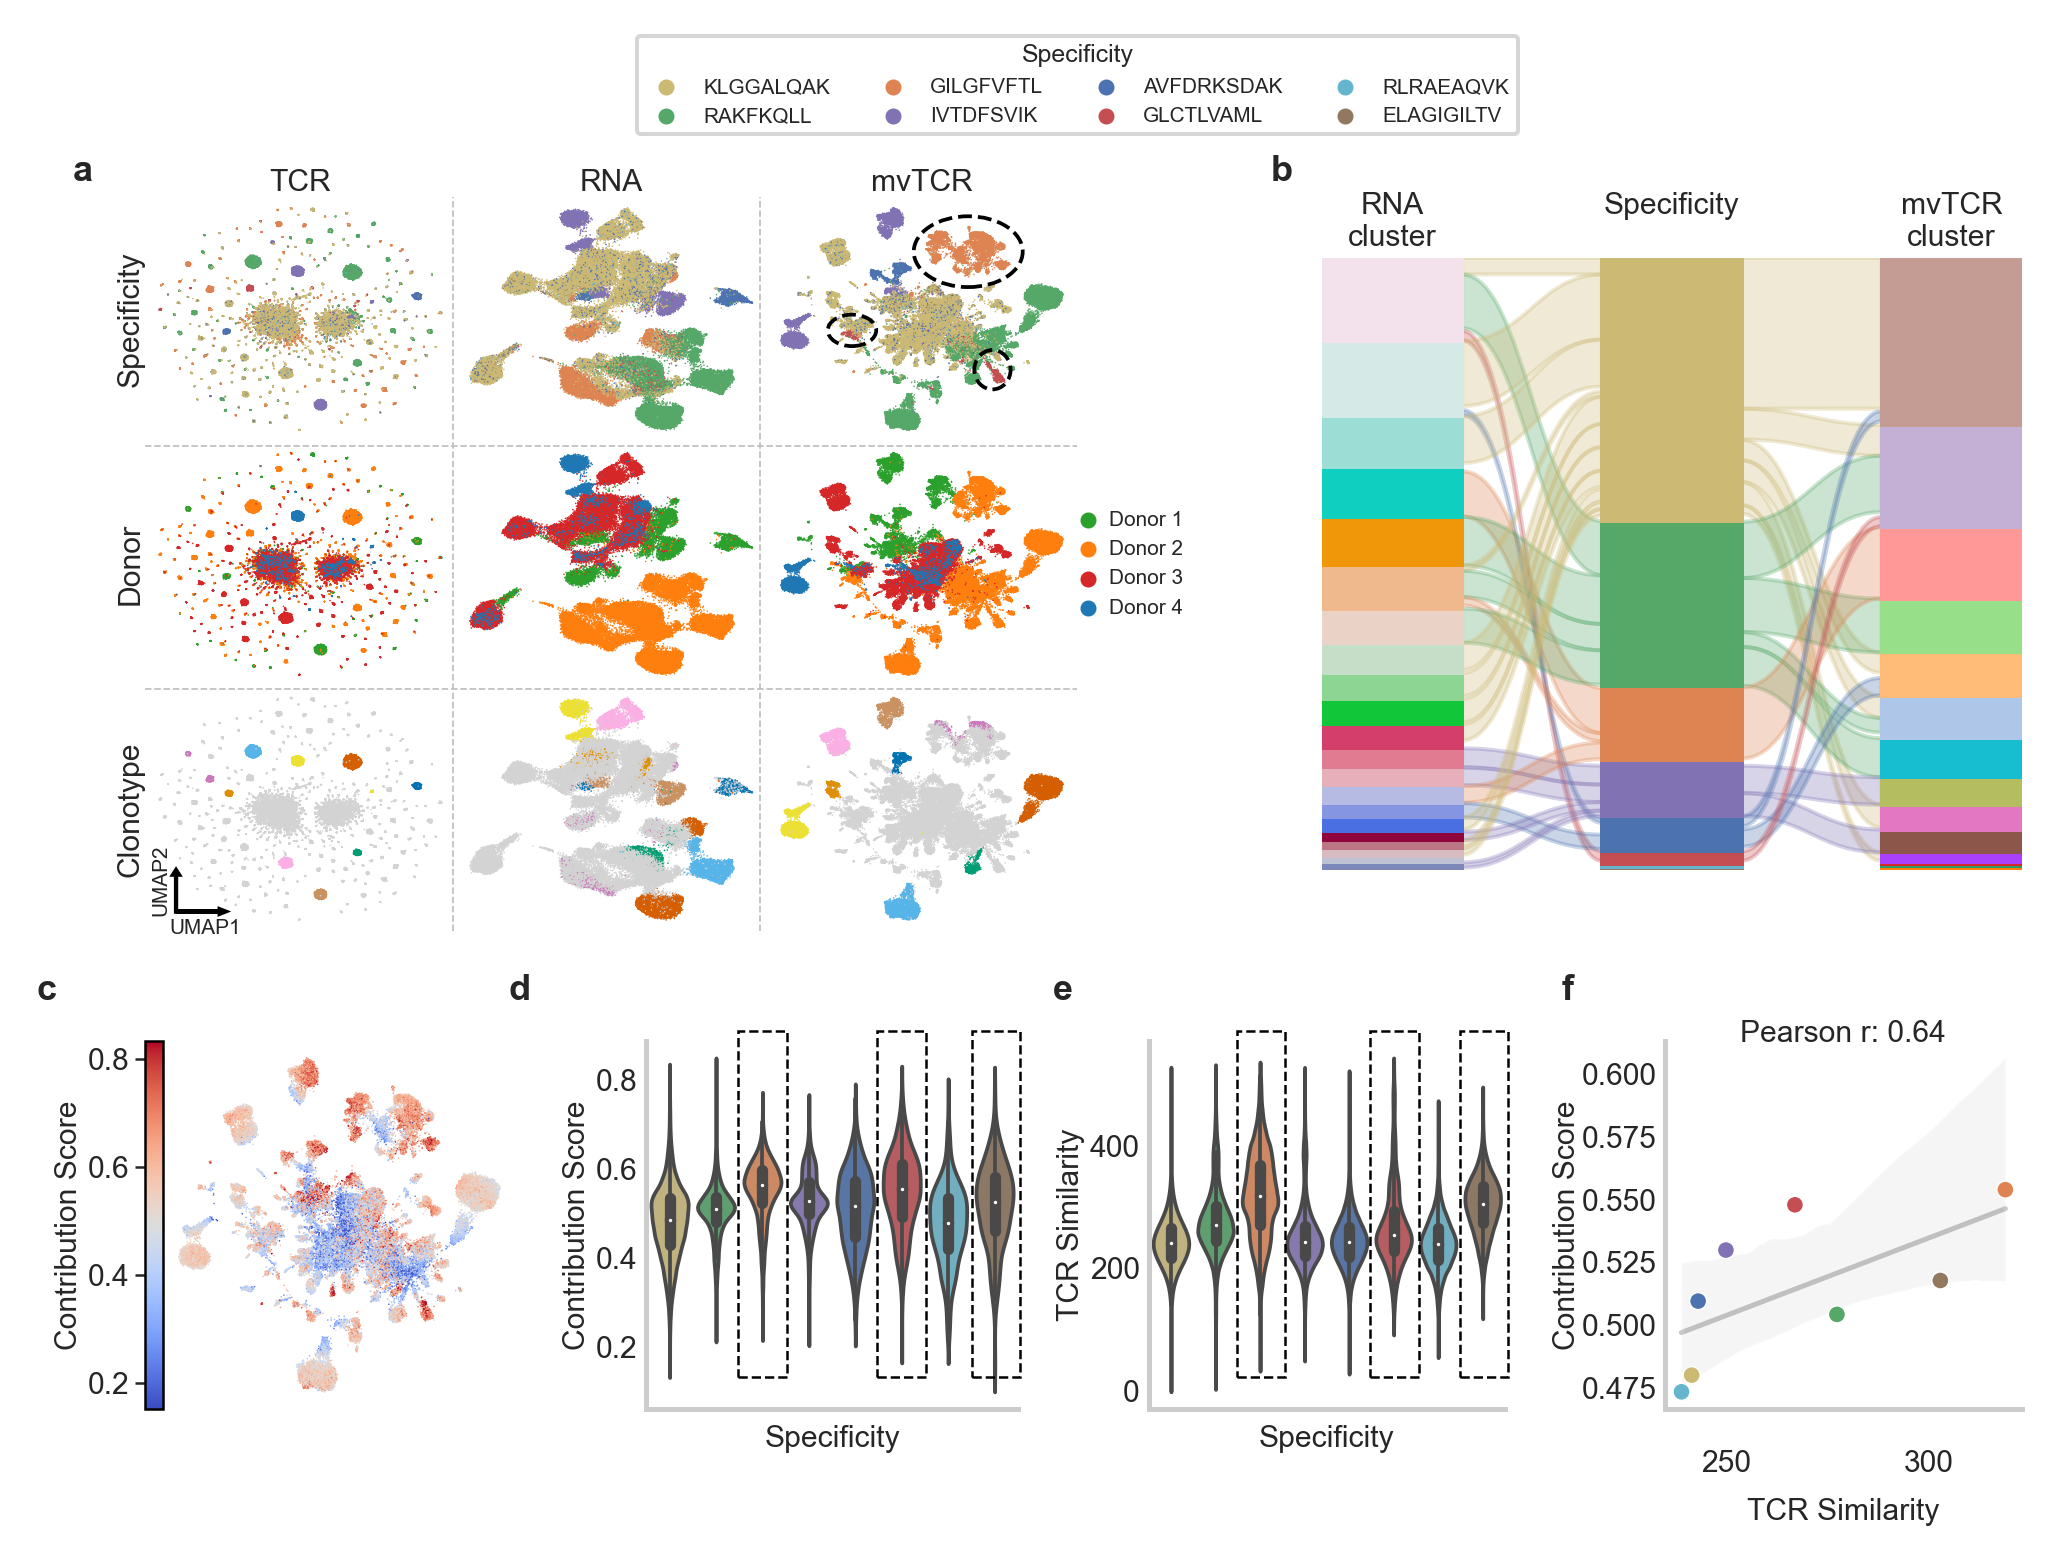

In [26]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.65),
                 dpi=DPI)
gridspecs = {}

#a    bbb c
#     bbb c
#     bbb c
#c  d  e

# a=Sketch, b=UMAPs, c=10x, d=Covid, e=Tessa


gridspecs["gs_a-e"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[4, 2],
    width_ratios=[1],
    hspace=0.2,
)

gridspecs["gs_ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[4, 3],
    wspace=0.3,
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][0],
    nrows=3,
    ncols=3,
    height_ratios=[1, 1, 1],
    width_ratios=[1, 1, 1],
    wspace=0.,
    hspace=0.,
)

gridspecs["gs_b"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][1],
    nrows=3,
    ncols=1,
    height_ratios=[0.1, 1, 0.1],
    width_ratios=[1],
    wspace=0.,
    hspace=0.,
)

gridspecs["gs_c-f"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.15,
)

gridspecs["gs_cd"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_c-f"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.35,
)

gridspecs["gs_d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cd"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[0.05, 1],
    wspace=0.0,
)

gridspecs["gs_ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_c-f"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.45,
)

ax_a = {}
for i in range(9):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])

ax_b = fig.add_subplot(gridspecs["gs_b"][1])

ax_c = fig.add_subplot(gridspecs["gs_ef"][0])
ax_d = fig.add_subplot(gridspecs["gs_d"][1])
ax_d_cb = fig.add_subplot(gridspecs["gs_d"][0])

ax_e = fig.add_subplot(gridspecs["gs_cd"][1])
ax_f = fig.add_subplot(gridspecs["gs_ef"][1])

plot_umap(adatas_fig['tcr'], 'binding_name', ax_a[0], xlabel='TCR', size=0.1, ylabel='Specificity')
plot_umap(adatas_fig['rna'], 'binding_name', ax_a[1], xlabel='RNA', size=0.1)
plot_umap(adatas_fig['moe'], 'binding_name', ax_a[2], xlabel='mvTCR', size=0.1, legend='Top', bbox=1.65)

middle_row = 'donor'
plot_umap(adatas_fig['tcr'], middle_row, ax_a[3], size=0.1, ylabel='Donor',)
plot_umap(adatas_fig['rna'], middle_row, ax_a[4], size=0.1)
plot_umap(adatas_fig['moe'], middle_row, ax_a[5], size=0.1, legend=True, bbox=1.4)

plot_umap(adatas_fig['tcr'], 'large_clonotype', ax_a[6], size=0.1, ylabel='Clonotype',)
plot_umap(adatas_fig['rna'], 'large_clonotype', ax_a[7], size=0.1)
plot_umap(adatas_fig['moe'], 'large_clonotype', ax_a[8], size=0.1)

plot_umap_axis(ax_a[6], offset=-0.01)

ax_a_full =  fig.add_subplot(gridspecs["gs_a"][:, :], sharex=ax_a[4])
# set background color to transparent and turn off the frame
ax_a_full.patch.set_alpha(0)
ax_a_full.axis("off")
# plot the vertical line
ax_a_full.plot([0.33, 0.33], [0, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0.66, 0.66], [0, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)

ax_a_full.plot([0, 1], [0.33, 0.33], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0, 1], [0.66, 0.66], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)

plot_sankey(df_sankey, ['leiden_rna', 'binding_name', 'leiden_moe'], 
            ['RNA\ncluster', 'Specificity\n', 'mvTCR\ncluster'], 
            [colors_rna, colors_binders, colors_moe],
            ax_b)

plot_tcrdist(df_dists, 'TCR Similarity', 'Binder', ax_c)

plot_umap(adatas_fig['moe'], 'Contribution TCR', ax_d, size=0.1)
plot_colorbar(adatas_fig['moe'].obs['Contribution TCR'].values, color_contribution, ax_d_cb)

plot_contribution(adatas_fig['moe'].obs, 'Contribution TCR', 'binding_name', ax_e)
plot_scatter(df_contribution_dists, 'TCR Similarity', 'Contribution Score', ax_f)


fig.text(0.095, 0.89, 'a', size='large', weight='bold')
fig.text(0.59, 0.89, 'b', size='large', weight='bold')

fig.text(0.08, 0.37, 'c', size='large', weight='bold')
fig.text(0.275, 0.37, 'd', size='large', weight='bold')
fig.text(0.5, 0.37, 'e', size='large', weight='bold')
fig.text(0.71, 0.37, 'f', size='large', weight='bold')

from matplotlib.patches import Ellipse, Rectangle
el_gil = Ellipse(xy=(0.465, 0.845), width=0.045, height=0.045, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)
el_glc1 = Ellipse(xy=(0.417, 0.795), width=0.02, height=0.02, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)
el_glc2 = Ellipse(xy=(0.475, 0.77), width=0.015, height=0.025, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)


bx_gil1 = Rectangle(xy=(0.37, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_gil2 = Rectangle(xy=(0.576, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

bx_glc1 = Rectangle(xy=(0.4275, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_glc2 = Rectangle(xy=(0.631, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

bx_ela1 = Rectangle(xy=(0.4665, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['ELAGIGILTV'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_ela2 = Rectangle(xy=(0.668, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['ELAGIGILTV'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

fig.patches.extend([el_gil, el_glc1, el_glc2, bx_gil1, bx_gil2, bx_glc1, bx_glc2, bx_ela1, bx_ela2,])

fig.tight_layout()
fig.savefig('../figures/fig_umap10x.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_umap10x.png',
           dpi=DPI, bbox_inches='tight')

In [27]:
print(f'Amount of cells: {len(adatas_fig["moe"])}')

Amount of cells: 61237


In [28]:
print('Amount of clusters')
for mod in ['tcr', 'rna', 'moe']:
    print(f'{mod} - {adatas_fig[mod].obs["leiden"].nunique()}')

Amount of clusters
tcr - 214
rna - 22
moe - 15


In [29]:
adatas_fig['moe'].obs.groupby('binding_name')['donor'].value_counts(normalize=True)

binding_name  donor  
ELAGIGILTV    Donor 1    0.713693
              Donor 2    0.116183
              Donor 3    0.116183
              Donor 4    0.053942
GILGFVFTL     Donor 2    0.733333
              Donor 1    0.265312
              Donor 3    0.001220
              Donor 4    0.000136
GLCTLVAML     Donor 2    0.983923
              Donor 1    0.015273
              Donor 4    0.000804
KLGGALQAK     Donor 3    0.727445
              Donor 2    0.136145
              Donor 1    0.105287
              Donor 4    0.031123
RLRAEAQVK     Donor 3    0.518421
              Donor 1    0.265789
              Donor 2    0.178947
              Donor 4    0.036842
AVFDRKSDAK    Donor 1    0.526781
              Donor 3    0.338177
              Donor 2    0.103134
              Donor 4    0.031909
IVTDFSVIK     Donor 4    0.487361
              Donor 1    0.477285
              Donor 3    0.021213
              Donor 2    0.014142
RAKFKQLL      Donor 2    0.995873
              Donor 1    0

In [30]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('GIL')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
GILGFVFTL     2         0.964905
              1         0.015989
              4         0.011653
              0         0.004878
              5         0.001762
              3         0.000542
              8         0.000136
              12        0.000136
Name: leiden, dtype: float64

In [31]:
adatas_fig['moe'][adatas_fig['moe'].obs['leiden']=='2'
                 ].obs['binding_name'].value_counts(normalize=True)

GILGFVFTL     0.991507
KLGGALQAK     0.005848
AVFDRKSDAK    0.001392
RAKFKQLL      0.000696
IVTDFSVIK     0.000418
GLCTLVAML     0.000139
Name: binding_name, dtype: float64

In [32]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('GIL')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
GILGFVFTL     3         0.610705
              13        0.223577
              5         0.110027
              1         0.023306
              10        0.016396
              0         0.006098
              17        0.002575
              19        0.002168
              15        0.002033
              7         0.001084
              8         0.000542
              2         0.000407
              4         0.000407
              18        0.000271
              6         0.000136
              9         0.000136
              21        0.000136
Name: leiden, dtype: float64

In [33]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('IVT')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
IVTDFSVIK     7         0.481527
              9         0.404278
              4         0.067350
              0         0.025986
              1         0.010783
              5         0.004066
              8         0.003005
              10        0.000707
              2         0.000530
              3         0.000530
              6         0.000530
              12        0.000354
              14        0.000354
Name: leiden, dtype: float64

In [34]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('IVT')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
IVTDFSVIK     11        0.333746
              12        0.308998
              16        0.148135
              20        0.092629
              10        0.042956
              1         0.034471
              2         0.007955
              0         0.007071
              7         0.003889
              9         0.003535
              19        0.003535
              8         0.002828
              5         0.002298
              13        0.001591
              17        0.001591
              18        0.001237
              6         0.000884
              14        0.000707
              21        0.000707
              3         0.000530
              15        0.000530
              4         0.000177
Name: leiden, dtype: float64

In [35]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('ELA')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
ELAGIGILTV    0         0.867220
              4         0.074689
              5         0.049793
              1         0.008299
Name: leiden, dtype: float64

In [36]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('ELA')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
ELAGIGILTV    19        0.585062
              7         0.170124
              8         0.082988
              1         0.074689
              18        0.049793
              10        0.033195
              0         0.004149
Name: leiden, dtype: float64

In [37]:
adatas_fig['moe'].obs.groupby('binding_name')['Contribution TCR'].mean().sort_values(ascending=False)

binding_name
GILGFVFTL     0.553778
GLCTLVAML     0.547759
IVTDFSVIK     0.529778
ELAGIGILTV    0.517691
AVFDRKSDAK    0.509496
RAKFKQLL      0.504218
KLGGALQAK     0.480070
RLRAEAQVK     0.473449
Name: Contribution TCR, dtype: float64

In [38]:
df_dists.groupby(['Binder'])['TCR Similarity'].mean().sort_values(ascending=False)

Binder
GILGFVFTL     318.749562
ELAGIGILTV    302.742986
RAKFKQLL      277.277746
GLCTLVAML     266.928773
IVTDFSVIK     249.937158
AVFDRKSDAK    243.099801
KLGGALQAK     241.503338
RLRAEAQVK     238.997472
Name: TCR Similarity, dtype: float64

In [39]:
df_dists['TCR Similarity'].mean()

242.3745626160282

In [40]:
adatas_fig['moe']

AnnData object with n_obs × n_vars = 61237 × 40
    obs: 'batch', 'donor', 'binding_name', 'clonotype', 'large_clonotype', 'celltype', 'Contribution TCR', 'leiden', 'treg_score', 'cd4 nv/cm_score', 'cd4/cd8_score', 'ifn response_score', 'proliferation_score', 'cd8 cytotoxic_score', 'cd8 cytokine_score', 'leiden_rna', 'leiden2_ct'
    uns: 'binding_name_colors', 'clones_per_cluster', 'corr_mvtcr_rna', 'leiden', 'leiden_colors', 'neighbors', 'pw_tcrdist', 'rna_conservation', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

## Supplementary Figure 1

In [41]:
donor_mapper = {
    'donor_1': 'Donor 1',
    'donor_2': 'Donor 2',
    'donor_3': 'Donor 3',
    'donor_4': 'Donor 4',
    'None': 'Pooled',
}

model_mapper = {
    'moe': 'mvTCR',
    'poe': 'PoE',
    'concat': 'Concat',
    'rna': 'RNA',
    'tcr': 'TCR',
}

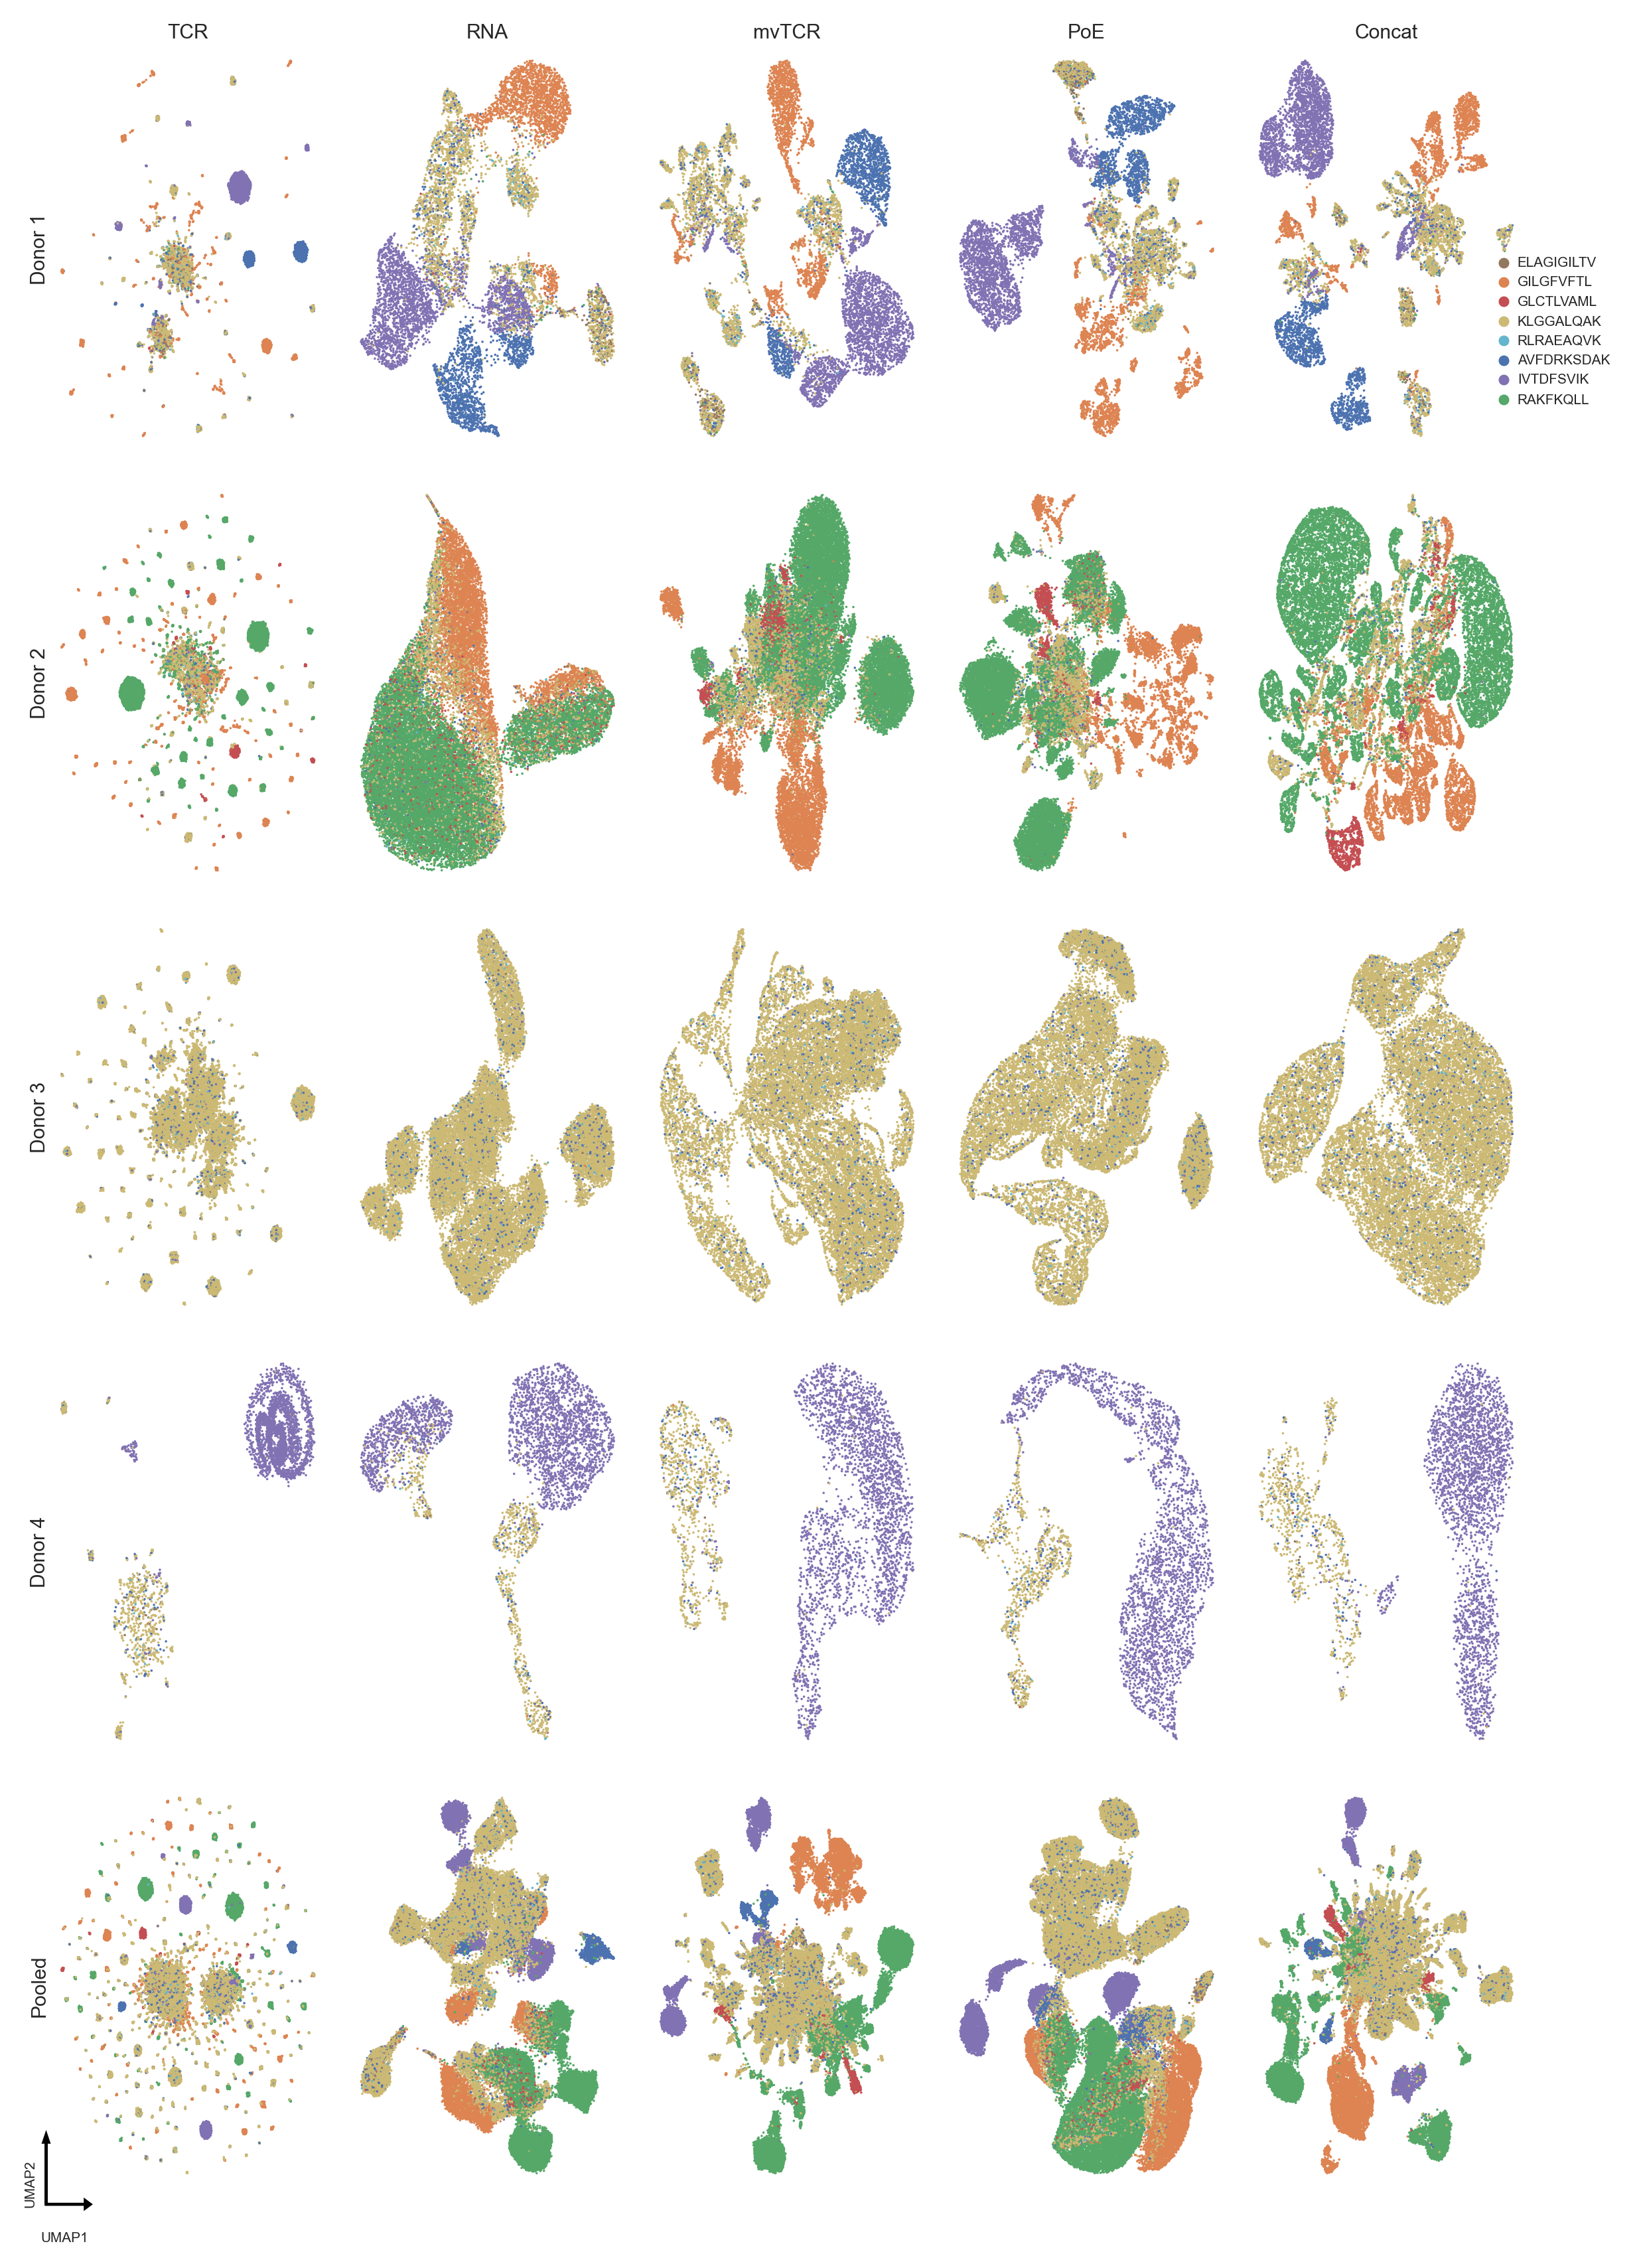

In [42]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 1.4),
                 dpi=DPI)
gridspecs = {}

# bbbbb
# bbbbb
# bbbbb
#  cdf

# b=UMAPs, c=10x, e=Tessa

gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=5,
    ncols=5,
    height_ratios=[1, 1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)

i = 0
axes = {}
for donor, model_dict in adatas.items():
    for model in ['tcr', 'rna', 'moe', 'poe', 'concat']:
        adata_tmp = model_dict[model]
        ax = fig.add_subplot(gridspecs["gs_a"][i])
        axes[i] = ax
    
        ylabel = donor_mapper[donor] if i%5==0 else None
        xlabel = model_mapper[model] if i<5 else None
        
        plot_umap(adata_tmp, 'binding_name', ax, ylabel=ylabel, xlabel=xlabel, legend=False, size=0.5, bbox=1.3)
        ax.legend().remove()
        i += 1
        
axes[4].legend(*axes[i-1].get_legend_handles_labels(), 
               markerscale=0.5, fontsize='x-small', handletextpad=0.0,
               loc='center right', bbox_to_anchor=(1.35, 0.3), frameon=False, ncol=1)
plot_umap_axis(axes[20], offset=0.1)    

fig.tight_layout()
fig.savefig('../figures/suppl_umap10x.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_umap10x.png',
           dpi=DPI, bbox_inches='tight')

## Suppl. 2

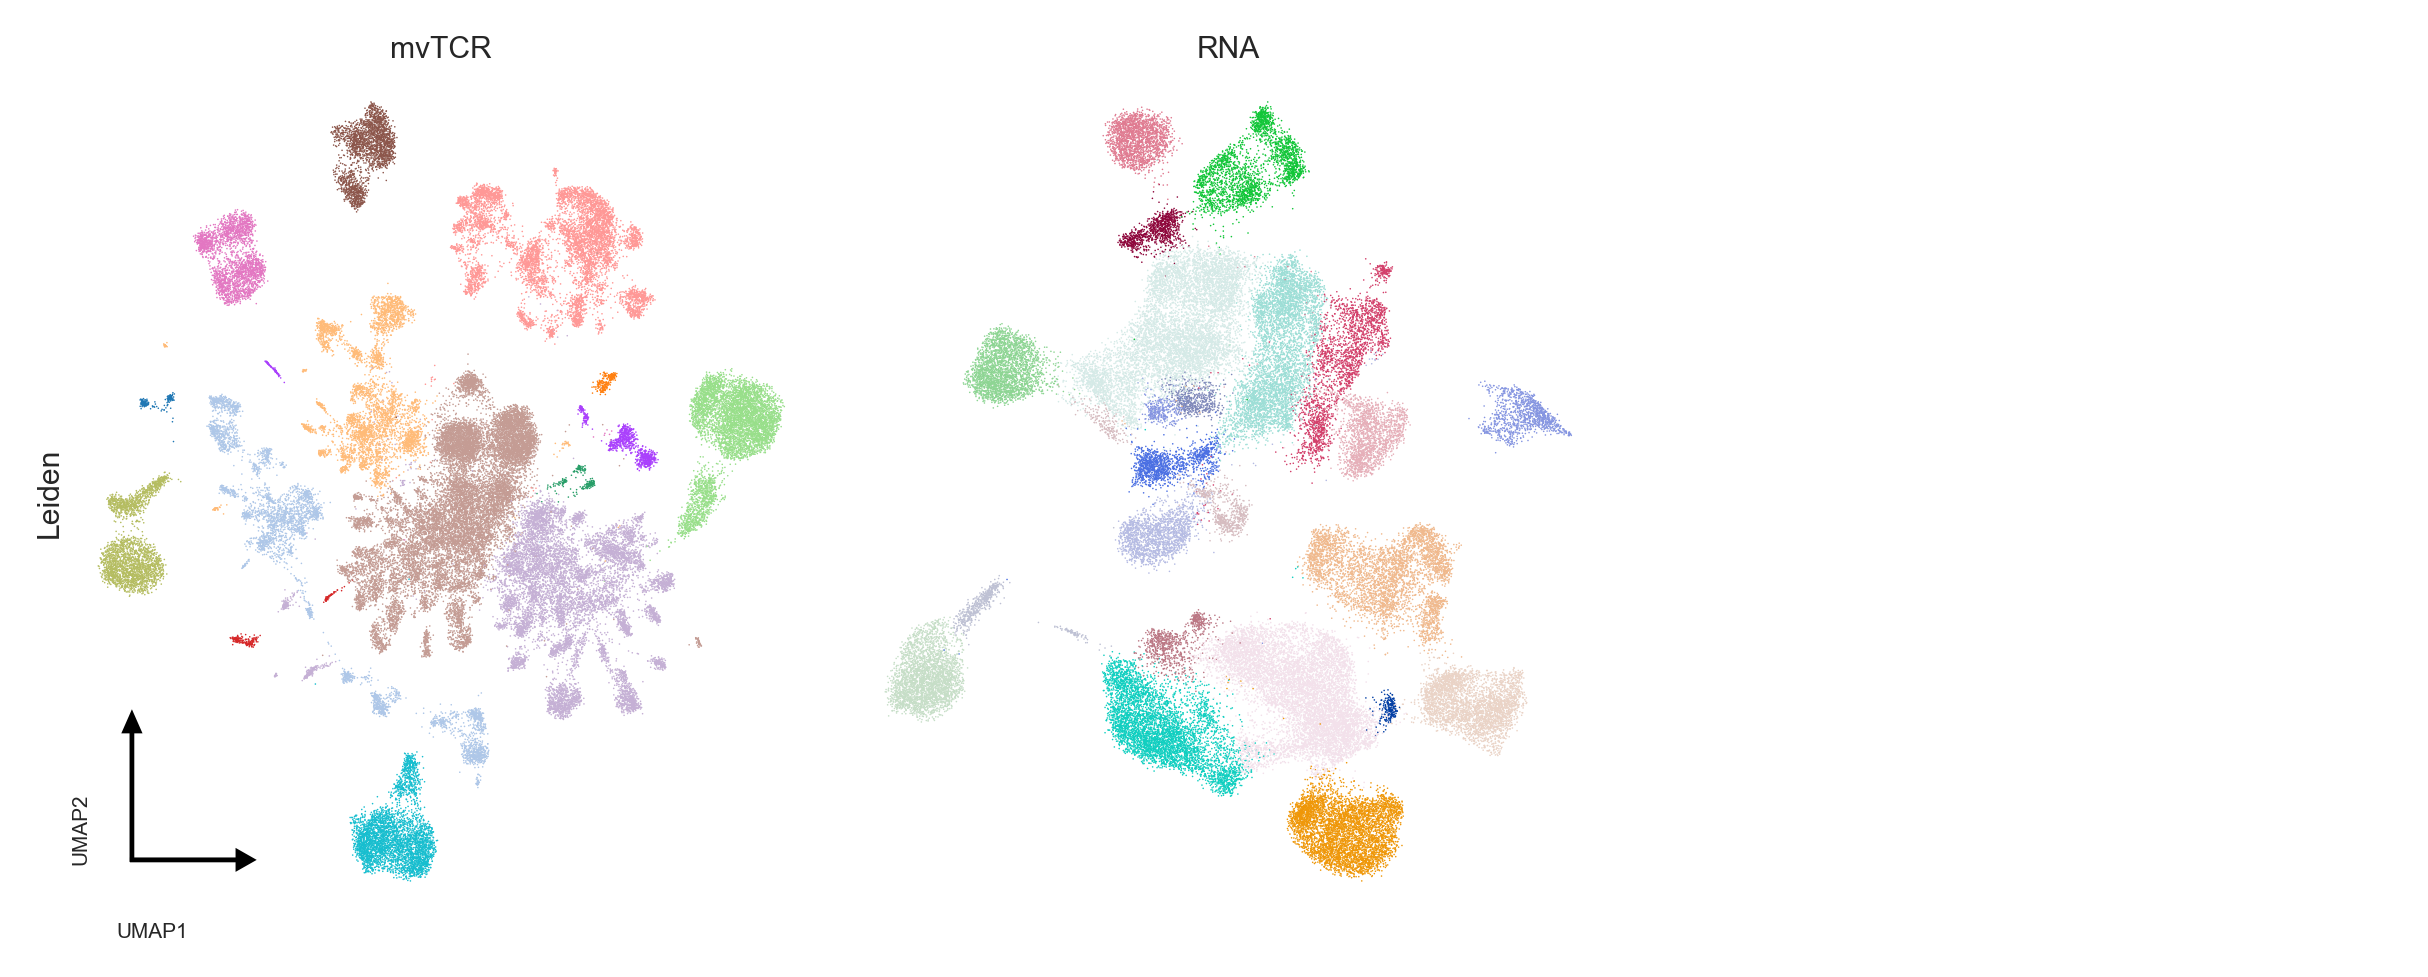

In [43]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.4),
                 dpi=DPI)
gridspecs = {}

gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1,1],
)


ax_mvtcr = fig.add_subplot(gridspecs["gs_a"][0])
ax_rna = fig.add_subplot(gridspecs["gs_a"][1])
ax_empty = fig.add_subplot(gridspecs["gs_a"][2])  
    
plot_umap(adatas_fig['moe'], 'leiden', ax_mvtcr, size=0.1, ylabel='Leiden', xlabel='mvTCR', cmap=colors_moe)
plot_umap(adatas_fig['rna'], 'leiden', ax_rna, size=0.1, xlabel='RNA', cmap=colors_rna)
plot_empty(ax_empty)

plot_umap_axis(ax_mvtcr, offset=0.)  


fig.tight_layout()
fig.savefig('../figures/suppl_10xclustering.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_10xclustering.png',
           dpi=DPI, bbox_inches='tight')

## Supplement Donor vs Epitope

<AxesSubplot:xlabel='binding_name'>

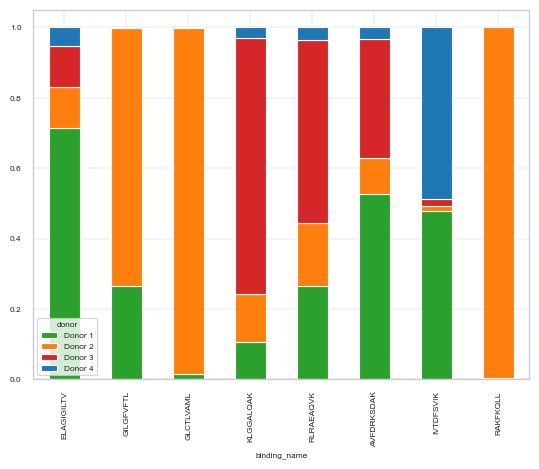

In [44]:
donor_by_epytope = adatas_fig['moe'].obs.groupby('binding_name')['donor'].value_counts(normalize=True)
donor_by_epytope = pd.DataFrame(donor_by_epytope).unstack()
donor_by_epytope.columns = donor_by_epytope.columns.droplevel(0)
donor_by_epytope.plot(kind='bar', stacked=True, color=colors_donor)

C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_20640\1517212762.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


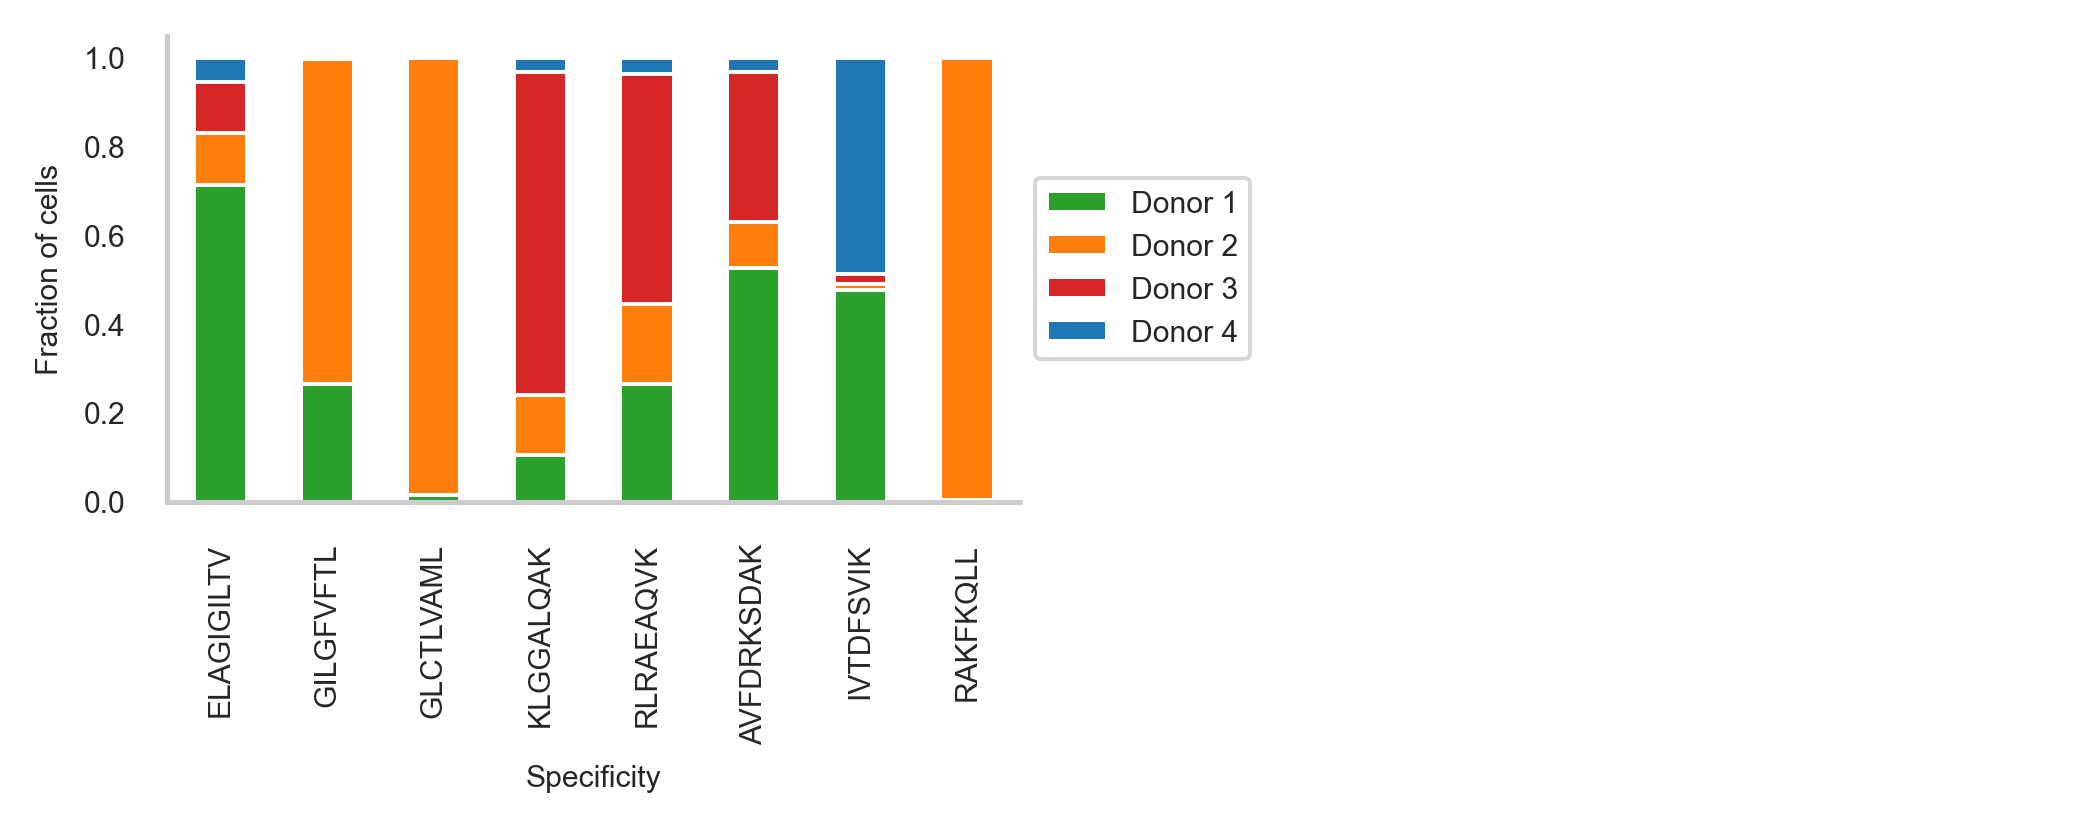

In [45]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.25),
                 dpi=DPI)
gridspecs = {}
gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.2
)


ax_bar = fig.add_subplot(gridspecs["gs_a"][0])
ax_empty = fig.add_subplot(gridspecs["gs_a"][1])  
    
donor_by_epytope.plot(kind='bar', stacked=True, color=colors_donor, ax=ax_bar)
sb.despine(ax=ax_bar)
ax_bar.grid(False)
ax_bar.legend(bbox_to_anchor=(1, 0.5), loc='center left').set_title(None)
ax_bar.set_xlabel('Specificity')
ax_bar.set_ylabel('Fraction of cells')

plot_empty(ax_empty)


fig.tight_layout()
fig.savefig('../figures/suppl_10xdonorBias.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_10xdonorBias.png',
           dpi=DPI, bbox_inches='tight')

## Supplement More than a Clonotype

In [46]:
def plot_umap_zoom(adata_full, grouping, ax, legend=None, ylabel=None, xlabel=None, size=0.2, bbox=1.6, cmap=None, zoom=True):
    if zoom:
        adata = adata_full[adata_full.obs['leiden']=='2']
        print(len(adata))
        adata = adata[adata.obsm['X_umap'][:, 0]>9]
        adata = adata[adata.obsm['X_umap'][:, 1]>12]
        print(len(adata))
    else:
        adata = adata_full
    xy = adata.obsm['X_umap']
    cmap = sb.color_palette('pastel')
    palette = {
        'nan': 'lightgray',
        '164.0': cmap[0],
        '18932.0': cmap[4],# 'tab:purple',
        '18875.0': cmap[1],# 'tab:orange',
        '1375.0': cmap[3],# 'tab:red',
        '19283.0': cmap[2],# 'tab:green',
        '18830.0': cmap[5],# 'tab:brown',
    }
    s = 0.1 if size == 0.5 else 0.5
    sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, color='lightgray', s=s, linewidth=0)
    
    adata = adata[adata.obs[grouping]!='nan']
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=size, linewidth=0, 
                          palette=palette)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    
    if zoom:
        ax.legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        labels = [el[:-2] for el in labels]
        ax.legend(handles, labels, markerscale=0.5, fontsize='x-small', loc='right', bbox_to_anchor=(1, 0.85),
                  handletextpad=0.001, frameon=False)

    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='medium', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='medium',
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [47]:
leiden_rna_in_2 = adatas_fig['moe'][(adatas_fig['moe'].obs['leiden']=='2')
                                   & (adatas_fig['moe'].obs['binding_name']=='GILGFVFTL')].obs['leiden_rna'].unique()
barcodes_in_2 = adatas_fig['moe'][(adatas_fig['moe'].obs['leiden']=='2')
                                 & (adatas_fig['moe'].obs['binding_name']=='GILGFVFTL')].obs.index

palette_rna_leiden = dict(zip(leiden_rna_in_2, sb.color_palette('deep')))
def plot_umap_rna_leiden(adata_full, grouping, ax, legend=None, ylabel=None, xlabel=None, size=0.2, bbox=1.6, cmap=None):
    # Draw Gray Map
    adata = adata_full.copy()
    xy = adata.obsm['X_umap']
    s = 0.1 if size == 0.5 else 0.5
    sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, color='lightgray', s=0.1, linewidth=0)
    
    # Draw Alpha map = leiden clusters that occur in latent_moe cluster 2
    adata = adata[adata.obs['leiden_rna'].isin(leiden_rna_in_2)]
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=0.5, linewidth=0, alpha=0.01,
                          palette=palette_rna_leiden)
    
    # Draw Cells that occur in latent_moe cluster 2
    adata = adata[barcodes_in_2]
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=0.5, linewidth=0, 
                          palette=palette_rna_leiden)

    
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:10], labels[:10], markerscale=0.5, fontsize='x-small', loc='right', bbox_to_anchor=(1.02, 0.87),
                handletextpad=0.001, frameon=False, ncol=2, columnspacing=0.5)


    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='medium', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='medium',
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [48]:
def plot_umap_mvtcr_leiden(adata_full, grouping, ax, legend=None, ylabel=None, xlabel=None, size=0.2, bbox=1.6, cmap=None):
    adata = adata_full.copy()
    adata.obs['leiden_rna_2'] = adata.obs.apply(lambda x: x['leiden_rna'] if x['leiden']=='2' else np.nan, axis=1)
    xy = adata.obsm['X_umap']
    s = 0.1 if size == 0.5 else 0.5
    sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, color='lightgray', s=s, linewidth=0)
    
    adata = adata[adata.obs['leiden_rna'].isin(leiden_rna_in_2)
                 & (adata.obs['leiden']=='2')]
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=size, linewidth=0, 
                          palette=palette_rna_leiden)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.legend().remove()#[], [], frameon=False)

    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='medium', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='medium',
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [49]:
cp = sb.color_palette('deep')
grays = sb.color_palette('Greys', n_colors=5)
palette_models = {
    'RNA': grays[0],   # cp[5],
    'TCR': grays[1],  #cp[4],
    'mvTCR': cp[1],  #cp[8],
}

def plot_conservation(ax):
    df_tmp = rna_conservation[rna_conservation['metric']=='Cell type']
    plot = sb.barplot(data=df_tmp, hue='model', y='score', ax=ax[0], x='metric',
                      palette=palette_models,
                      hue_order=['RNA', 'TCR', 'mvTCR']
                     )
    ax[0].set_ylabel('NMI Cell Types', labelpad=1)
    ax[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(1.75, 1.15), frameon=False)
    
    df_tmp = rna_conservation[rna_conservation['metric']=='RNA-Cluster']
    plot = sb.barplot(data=df_tmp, hue='model', y='score', ax=ax[1], x='metric',
                      palette=palette_models,
                      hue_order=['TCR', 'mvTCR']
                     )
    ax[1].set_ylabel('NMI RNA-Clusters', labelpad=1)
    ax[1].legend().remove()

    for i in range(2):
        ax[i].grid(False)
        sb.despine(ax=ax[i])
        ax[i].set_xticklabels([])
        ax[i].set_xlabel(None, labelpad=-5)
        ax[i].tick_params('y', pad=-3)

In [50]:
clones_per_cluster['metric'] = 'dummy'
def plot_cts(ax):
    plot = sb.barplot(data=clones_per_cluster, hue='model', y='clonotype', ax=ax, x='metric',
                      palette=palette_models, #scale='width',
                      hue_order=['RNA', 'TCR', 'mvTCR'],
                      capsize=0.15,
                      errwidth=1,
                      #log_scale=True
                     )
    ax.set_ylabel('Amount Clones (logged)', labelpad=1)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_xticklabels([])
    ax.set_xlabel(None, labelpad=-5)
    ax.tick_params('y', pad=-3)
    ax.set_yscale('log')
    #ax.set_ylim((-1, clones_per_cluster['clonotype'].max()+3))

In [51]:
def p_2_sign(val):
    if val == -99:
        return ''
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    else:
        return ''

In [52]:
palette_corr = sb.color_palette('ch:', as_cmap=True)
color_corr_reg = sb.color_palette('Paired')[9]
def plot_correlation(ax):
    x = 'RNA-Distance'
    y = 'mvTCR-Distance'
    corr_test = pearsonr(corr_mvtcr_rna[x].values, corr_mvtcr_rna[y].values)
    plot = sb.regplot(data=corr_mvtcr_rna, x=x, y=y, scatter=False, ax=ax, 
                      line_kws={'zorder': -1, 'linewidth': 1, 'color': color_corr_reg})
    sb.scatterplot(data=corr_mvtcr_rna, x=x, y=y, hue='log_expansion', 
                   ax=ax, size=1., zorder=1, palette=palette_corr, alpha=0.5,
                  )

    print(corr_test)
    plot.set_title(f'Pearson r: {corr_test[0]:.2f} ({p_2_sign(corr_test[1])})')
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=0)
    ax.set_xlabel(ax.get_xlabel(), labelpad=0)
    ax.legend().remove()#(title=None, handletextpad=0.)
    ax.tick_params('y', pad=-3)
    ax.tick_params('x', pad=-3)

7182
7164
PearsonRResult(statistic=0.8021736238246943, pvalue=8.5423567704601e-57)


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_20640\2947830052.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


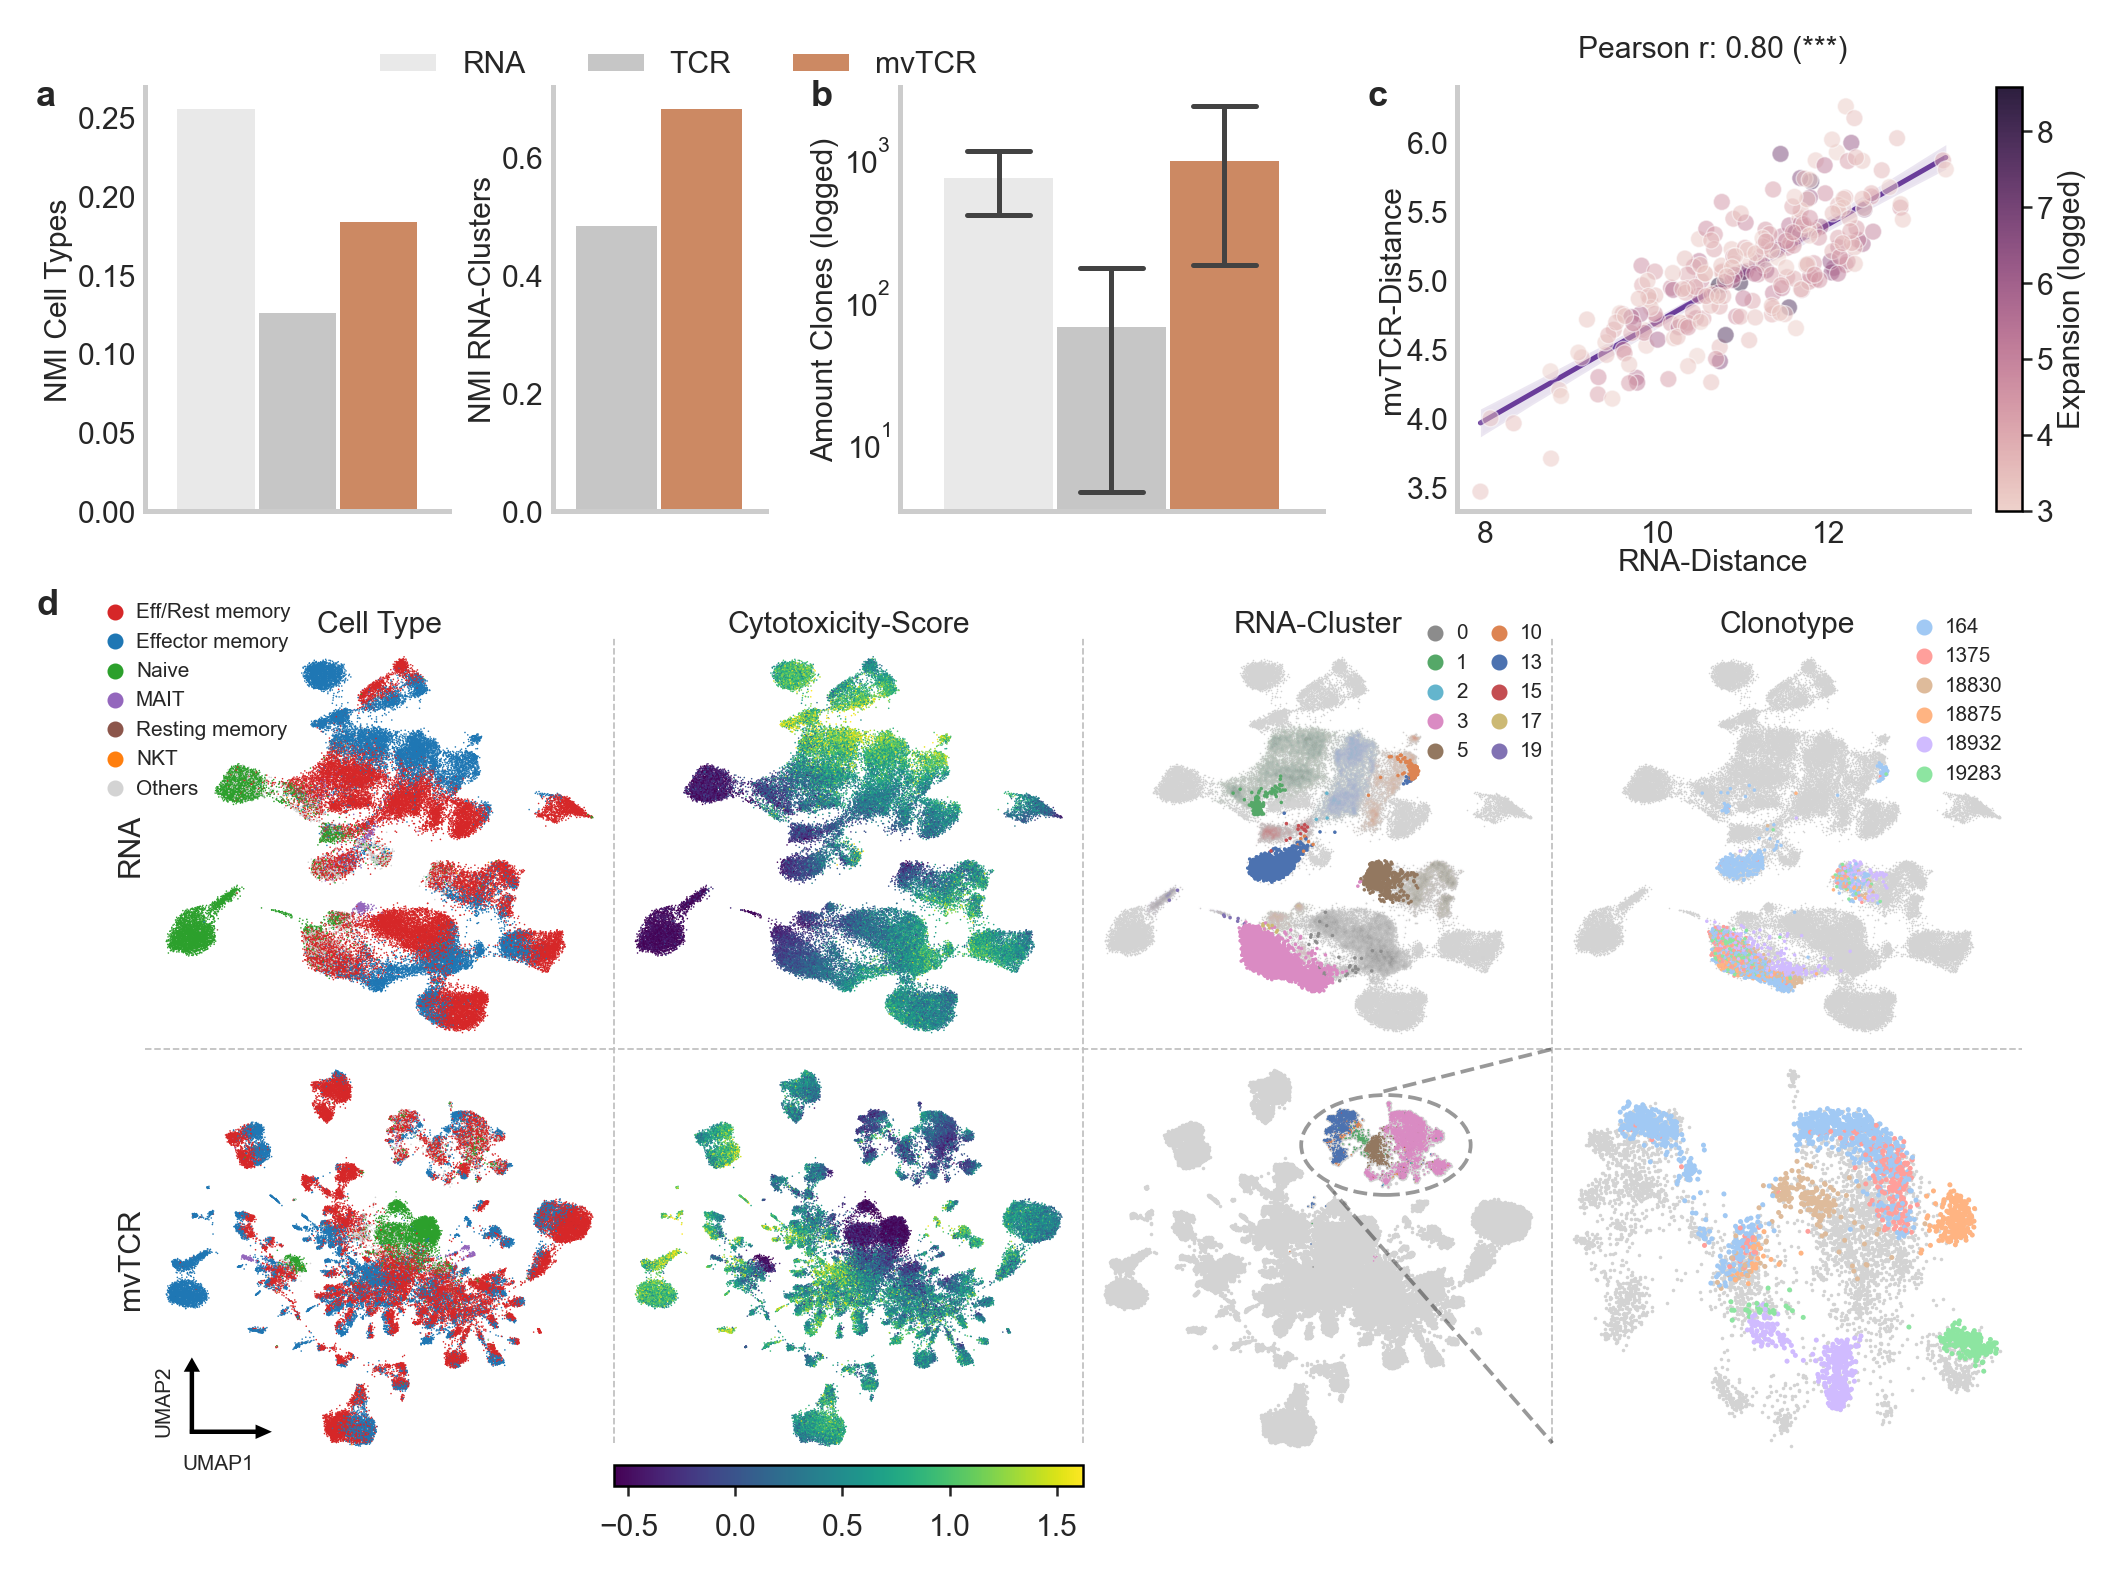

In [53]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.75),
                 dpi=DPI)
gridspecs = {}

#a    bbb c
#     bbb c
#     bbb c
#c  d  e

# a=Sketch, b=UMAPs, c=10x, d=Covid, e=Tessa


gridspecs["gs_a-e"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[2, 4],
    width_ratios=[1],
    hspace=0.2,
)


gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][1],
    nrows=3,
    ncols=4,
    height_ratios=[1, 1, 0.05],
    width_ratios=[1, 1, 1, 1],
    wspace=0.,
    hspace=0.,
)

gridspecs["gs_b-d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][0],
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1.1, 0.75, 1],
    wspace=0.25,
    hspace=0.,
)

gridspecs["gs_b"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_b-d"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 0.7],
    wspace=0.4,
    hspace=0.,
)

gridspecs["gs_d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_b-d"][2],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 0.05],
    wspace=0.1,
    hspace=0.,
)


ax_a = {}
for i in range(12):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])

for i in range(8, 12):
    if i == 9:
        continue
    plot_empty(ax_a[i])

ax_b1 = fig.add_subplot(gridspecs["gs_b"][0])
ax_b2 = fig.add_subplot(gridspecs["gs_b"][1])
ax_c = fig.add_subplot(gridspecs["gs_b-d"][1])
ax_d = fig.add_subplot(gridspecs["gs_d"][0])
ax_cbar = fig.add_subplot(gridspecs["gs_d"][1])

col = 'celltype'
plot_umap(adatas_fig['rna'], col, ax_a[0], xlabel='Cell Type', size=0.1, ylabel='RNA', legend=True, bbox=0.35, bbox2=0.85)
plot_umap(adatas_fig['moe'], col, ax_a[4], size=0.1, ylabel='mvTCR')

col = 'cd8 cytotoxic_score'
plot_umap(adatas_fig['rna'], col, ax_a[1], size=0.1, xlabel='Cytotoxicity-Score')
plot_umap(adatas_fig['moe'], col, ax_a[5], size=0.1)
plot_colorbar(adatas_fig['moe'].obs[col].values, 'viridis', ax_a[9], position='left', title=None, orientation='horizontal')

plot_umap_rna_leiden(adatas_fig['rna'], 'leiden', ax_a[2], size=0.1, xlabel='RNA-Cluster')
plot_umap_mvtcr_leiden(adatas_fig['moe'], 'leiden_rna', ax_a[6], size=0.1)

col = 'leiden2_ct'
plot_umap_zoom(adatas_fig['rna'], col, ax_a[3], size=0.5, xlabel='Clonotype', zoom=False)
plot_umap_zoom(adatas_fig['moe'], col, ax_a[7], size=1)
plot_umap_axis(ax_a[4], offset=-0.01)

plot_conservation(ax=[ax_b1, ax_b2])
plot_cts(ax_c)
plot_correlation(ax_d)
plot_colorbar(corr_mvtcr_rna['log_expansion'].values, palette_corr, ax_cbar, 
              title='Expansion (logged)', position='right', clip=False)

ax_a_full =  fig.add_subplot(gridspecs["gs_a"][:, :], sharex=ax_a[4])
# set background color to transparent and turn off the frame
ax_a_full.patch.set_alpha(0)
ax_a_full.axis("off")

# plot umap seperators
ax_a_full.plot([0.25, 0.25], [0.05, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0.5, 0.5], [0.05, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0.75, 0.75], [0.05, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0, 1], [0.515, 0.515], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)

# plot zoom
ax_a_full.plot([0.66, 0.75], [0.465, 0.515], c='black', linestyle='dashed', linewidth=0.75, alpha=0.4,
               transform=ax_a_full.transAxes)
ax_a_full.plot([0.63, 0.75], [0.355, 0.05], c='black', linestyle='dashed', linewidth=0.75, alpha=0.4, 
               transform=ax_a_full.transAxes)

fig.text(0.08, 0.87, 'a', size='large', weight='bold')
fig.text(0.40, 0.87, 'b', size='large', weight='bold')
fig.text(0.63, 0.87, 'c', size='large', weight='bold')

fig.text(0.08, 0.59, 'd', size='large', weight='bold')

el_leiden2 = Ellipse(xy=(0.6375, 0.2975), width=0.07, height=0.055, edgecolor='black', alpha=0.4,
                     fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)

fig.patches.extend([el_leiden2])

fig.tight_layout()
fig.savefig('../figures/fig_10xRNA.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_10xRNA.png',
           dpi=DPI, bbox_inches='tight')

In [54]:
clones_per_cluster.groupby('model')['clonotype'].mean()

model
RNA      728.318182
TCR       65.556075
mvTCR    946.200000
Name: clonotype, dtype: float64

In [55]:
rna_conservation

model       metric     score
0  mvTCR    Cell type  0.184442
1    RNA    Cell type  0.256251
2    TCR    Cell type  0.126952
3  mvTCR  RNA-Cluster  0.684403
4    TCR  RNA-Cluster  0.486574